# <center>Deep clustering of French official announcements on bankruptcy proceedings </center>

## <center> Project of *Machine Learning for NLP* - ENSAE 3rd Year - April 2021 </center> &nbsp; <center> Thomas JACQUOT, Baptiste ARTUR </center>

## Project intention  

The description has already been sent to instructors. You will find it below and on the  inside the READ.ME file in the associated GitLab repository.  

1. In France, the administration must guarantee transparency in the economic and financial sphere. Therefore, the services produce an official journal called BODACC (it stands for “Bulletin officiel des annonces civiles et commerciales”). Business information about firms from founding to deregistration is recorded in this bulletin. It includes declarations of a sale, companies’ transfers, bankruptcy proceedings, filing of annual accounts, … In this project, we focus our attention on bankruptcy proceedings (“procédures collectives” in French also denoted by PCLA). The objective is to group the PCLAs by type in order to know the exact nature of the difficulties faced by the companies.​​​​​

1. ​To achieve this task, we will use a dataset containing PCLA from 2017 to 2019. This dataset represents more than 500 000 court rulings. It is available on the following GitLab repository:  https://gitlab.com/Baartur/pcla-clustering. Our dataset contains 3 levels of information for each PCLA. From the least precise to the most precise level, we have its family (e.g. "Jugement de clôture "), its nature (e.g. "Jugement de clôture pour insuffisance d'actif"), and its complement (e.g. "Jugement prononçant la clôture du plan de cession pour insuffisance d'actif "). The complement to the judgment is exhaustive and sometimes takes up two or even three sentences. We will therefore try to categorize the PCLAs by using their judgment complement. The families and natures of judgments will be useful for (1) defining the target of our supervised sequence classification models, and (2) quantitatively evaluating our unsupervised clustering models.​

1. ​We identify two main families of NLP models, the classical models that we oppose to the deep learning models. In our answer to the problem of categorizing PCLAs, we will try to compare these two approaches to highlight their advantages and disadvantages, and finally select the most relevant one for our use case. The LDA model will be our benchmark model. LDA is indeed a classical topic modeling approach, widely used, and relatively interpretable.  However, LDA remains a "bag of words" approach, not deducing any meaning from the arrangement of words in sentences. To remedy the performance limitation of this type of modeling, we will test more complex models based on deep learning methods.

1.  ​Firstly, we will realize a topic modeling with Gensim’s LDA in order to understand the different themes contained by the documents. To visualize the different topic clusters PyLDAvis will be useful.

1.  ​Then, we will compare this benchmark model to one or several deep learning models. This model could be unsupervised or supervised, using the jugement family as a target or even by designing a manual labeling process that would feed the target. We could use methods that will directly perform topic modeling task, or we can couple an embedding layer with a numerical clustering layer (e.g. models for these 2 possibilities: Word2Vec, CAMENBERT, Sentence-BERT, LSTM, FastText, GPT2 combined with LGBM, KMEANS, ANN). We will test it qualitatively using dimensionality reduction techniques (like PCA, TSNE). We will then evaluate it quantitatively using different scores (like proportion scores) computed on the test set of the source dataset. 

1.  ​We will then draw conclusions and possible future work. 


# Table Of Content

## 1 [Minimum requirements and advices ](#requirements_advices)
### &emsp; 1.1 [ Advices for code execution](#advices)
### &emsp; 1.2 [ Packages requirements](#requirements)
### &emsp; 1.3 [Raw Data Loading](#raw_loading)

## 2 [Data preparation](#data_prep)
### &emsp; 2.1 [Resolve encoding problems](#resolve_encoding)
### &emsp; 2.2 [Statistical exploration](#explo)
### &emsp; 2.3 [Text preprocessing](#text_prepro)



## 3 [Classification tasks (Supervised and unsupervised)](#classif)
### &emsp; 3.1 [Problematization](#problematization)
### &emsp; 3.2 [TF-IDF : a bag of words approach](#tf_idf)
### &emsp; 3.3 [Word2Vec embeddings](#word2vec)
### &emsp; 3.4 [Word embeddings using a language model :  BERT](#bert)




## 1 Minimum requirements and advices  <a class="anchor" id="requirements_advices"></a>

### &nbsp; &nbsp;  1.1 Advices for code execution <a class="anchor" id="advices"></a>

If you want to verify that the code can be executed, we advice you to skip the part **Preprocess raw data** since its execution can last more than 2 hours.  

### &nbsp; &nbsp;  1.2 Packages requirements <a class="anchor" id="requirements"></a>

#### General imports  <a class="anchor" id="general_requirements"></a>

In [1]:
# Data manipulations
import pandas as pd
import numpy as np
import re
import math 

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm #for progress bars
tqdm.pandas()

# Date and time management
from timeit import default_timer as timer
from datetime import timedelta

C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Download spacy model before importing them
!python -m spacy download fr_core_news_md

2021-04-22 07:47:38.134838: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-04-22 07:47:38.134940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [2]:
# NLP 
import ftfy

import spacy

import nltk

nlp = spacy.load('fr_core_news_md')


#### Imports for 3.2 TF-IDF approach <a class="anchor" id="word2vec_requirements"></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
sns.set(style='white', context='notebook', rc={'figure.figsize':(11,8)})

#### Imports for 3.3 Word2Vec embeddings <a class="anchor" id="word2vec_requirements"></a>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.cluster import KMeans
sns.set(style='white', context='notebook', rc={'figure.figsize':(11,8)})

#### Imports for 3.4 BERT  <a class="anchor" id="bert_requirements"></a>

In [4]:
! pip install sentence-transformers

In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Options
sns.set(style='white', context='notebook', rc={'figure.figsize':(11,8)})

**Go directly to [BERT part](#bert)**

### &nbsp; &nbsp;  1.3 Raw Data Loading <a class="anchor" id="raw_loading"></a>

In [4]:
df = pd.read_csv("../data/project_dataset-pcla_2017_to_2019.csv", sep=";")

In [5]:
df

parutionID date_parution    numeroRCS  \
0       20170001_1106_2017-01-03    2017-01-03  390432326.0   
1       20170001_1107_2017-01-03    2017-01-03  500105242.0   
2       20170001_1108_2017-01-03    2017-01-03  484032008.0   
3       20170001_1109_2017-01-03    2017-01-03  820494573.0   
4       20170001_1110_2017-01-03    2017-01-03          NaN   
...                          ...           ...          ...   
530345  20190251_3469_2019-12-31    2019-12-31  524497237.0   
530346  20190251_3470_2019-12-31    2019-12-31  514791268.0   
530347  20190251_3471_2019-12-31    2019-12-31  404386005.0   
530348  20190251_3472_2019-12-31    2019-12-31  800121030.0   
530349  20190251_3473_2019-12-31    2019-12-31  793295270.0   

                                                tribunal  \
0                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
1                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
2                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
3                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
4                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
...                                                  ...   
530345  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530346  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530347  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530348  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530349  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   

                                                 activite  \
0                                            non précisée   
1                                            non précisée   
2                                            non précisée   
3                                            non précisée   
4                                             agriculteur   
...                                                   ...   
530345                   Travaux de câblage en téléphonie   
530346  Travaux de maçonnerie générale rénovation de B...   
530347  Terrassements divers construction de maisons i...   
530348  Nettoyage industriel en cuisine commerciale et...   
530349  Construction et rénovation D' autres bâtiments...   

                                          adresseComplete codePostal  \
0                           rue du Hautbert 02500 Hirson       02500   
1       5 Bis avenue du Général de Gaulle 02700 Tergnier       02700   
2                6 rue du Lavoir 02860 Nouvion-le-Vineux       02860   
3                           rue du Hautbert 02500 Hirson       02500   
4                  1 route de Saint-Michel 02830 Watigny       02830   
...                                                   ...        ...   
530345        zone industrielle de Champigny 97224 Ducos       97224   
530346  quartier Augrain route de Fonds Brûlé 97231 Le...      97231   
530347  parc d'Activites de la Semair Bat A Bahamas NÈ...      97231   
530348                 chemin Croix Guy 97220 La Trinite       97220   
530349  520 lotissement Affut Horizon Est Chemier du G...      97232   

            dateJu             familleJu  \
0       2016-12-14  Jugement d'ouverture   
1       2016-12-14  Jugement d'ouverture   
2       2016-12-14  Jugement d'ouverture   
3       2016-12-14  Jugement d'ouverture   
4       2016-12-14   Jugement prononçant   
...            ...                   ...   
530345  2019-10-18       Avis de dÃ©pÃ´t   
530346  2019-10-18       Avis de dÃ©pÃ´t   
530347  2019-10-10       Avis de dÃ©pÃ´t   
530348  2019-11-08       Avis de dÃ©pÃ´t   
530349  2019-10-18       Avis de dÃ©pÃ´t   

                                                 natureJu  \
0          Jugement d'ouverture de liquidation judiciaire   
1          Jugement d'ouverture de liquidation judiciaire   
2       Jugement d'ouverture d'une procédure de sauveg...   
3          Jugement d'ouverture de liquidation judiciaire   
4                               Autre jugement prononçant   
...                                                

## 2 Data preparation  <a class="anchor" id="data_prep"></a>

We notice that some variables suffer from encoding problems (e.g. *Avis de dÃ©pÃ´t* that appears in *familleJu*) or in the following example : 

In [6]:
df.iloc[530347]['complementJu']

"L'Ã©tat des crÃ©ances est dÃ©posÃ© au greffe oÃ¹ tout intÃ©ressÃ© peut prÃ©senter rÃ©clamation devant le juge-commissaire dans le dÃ©lai d'un mois Ã\xa0 compter de la prÃ©sente publication."

### &nbsp; &nbsp;  2.1 Resolve encoding problems <a class="anchor" id="resolve_encoding"></a>

In [7]:
df.loc[:, 'familleJu'] = df.familleJu.progress_apply(lambda x: ftfy.fix_text(x))
df.loc[:, 'natureJu'] = df.natureJu.progress_apply(lambda x: ftfy.fix_text(x))
df.loc[:, 'complementJu'] = df.complementJu.progress_apply(lambda x: ftfy.fix_text(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530350/530350 [11:26<00:00, 771.99it/s]


We can check that the correct changes have been done. Let's have a look at the previous example. 

In [8]:
df.iloc[530347]['complementJu']

"L'état des créances est déposé au greffe où tout intéressé peut présenter réclamation devant le juge-commissaire dans le délai d'un mois à compter de la présente publication."

In [9]:
df

parutionID date_parution    numeroRCS  \
0       20170001_1106_2017-01-03    2017-01-03  390432326.0   
1       20170001_1107_2017-01-03    2017-01-03  500105242.0   
2       20170001_1108_2017-01-03    2017-01-03  484032008.0   
3       20170001_1109_2017-01-03    2017-01-03  820494573.0   
4       20170001_1110_2017-01-03    2017-01-03          NaN   
...                          ...           ...          ...   
530345  20190251_3469_2019-12-31    2019-12-31  524497237.0   
530346  20190251_3470_2019-12-31    2019-12-31  514791268.0   
530347  20190251_3471_2019-12-31    2019-12-31  404386005.0   
530348  20190251_3472_2019-12-31    2019-12-31  800121030.0   
530349  20190251_3473_2019-12-31    2019-12-31  793295270.0   

                                                tribunal  \
0                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
1                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
2                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
3                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
4                 TRIBUNAL DE GRANDE INSTANCE DE LAON 02   
...                                                  ...   
530345  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530346  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530347  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530348  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   
530349  TRIBUNAL MIXTE DE COMMERCE DE FORT-DE-FRANCE 972   

                                                 activite  \
0                                            non précisée   
1                                            non précisée   
2                                            non précisée   
3                                            non précisée   
4                                             agriculteur   
...                                                   ...   
530345                   Travaux de câblage en téléphonie   
530346  Travaux de maçonnerie générale rénovation de B...   
530347  Terrassements divers construction de maisons i...   
530348  Nettoyage industriel en cuisine commerciale et...   
530349  Construction et rénovation D' autres bâtiments...   

                                          adresseComplete codePostal  \
0                           rue du Hautbert 02500 Hirson       02500   
1       5 Bis avenue du Général de Gaulle 02700 Tergnier       02700   
2                6 rue du Lavoir 02860 Nouvion-le-Vineux       02860   
3                           rue du Hautbert 02500 Hirson       02500   
4                  1 route de Saint-Michel 02830 Watigny       02830   
...                                                   ...        ...   
530345        zone industrielle de Champigny 97224 Ducos       97224   
530346  quartier Augrain route de Fonds Brûlé 97231 Le...      97231   
530347  parc d'Activites de la Semair Bat A Bahamas NÈ...      97231   
530348                 chemin Croix Guy 97220 La Trinite       97220   
530349  520 lotissement Affut Horizon Est Chemier du G...      97232   

            dateJu             familleJu  \
0       2016-12-14  Jugement d'ouverture   
1       2016-12-14  Jugement d'ouverture   
2       2016-12-14  Jugement d'ouverture   
3       2016-12-14  Jugement d'ouverture   
4       2016-12-14   Jugement prononçant   
...            ...                   ...   
530345  2019-10-18         Avis de dépôt   
530346  2019-10-18         Avis de dépôt   
530347  2019-10-10         Avis de dépôt   
530348  2019-11-08         Avis de dépôt   
530349  2019-10-18         Avis de dépôt   

                                                 natureJu  \
0          Jugement d'ouverture de liquidation judiciaire   
1          Jugement d'ouverture de liquidation judiciaire   
2       Jugement d'ouverture d'une procédure de sauveg...   
3          Jugement d'ouverture de liquidation judiciaire   
4                               Autre jugement prononçant   
...                                                

Then, we export this dataset to save the transformations. For the future executions it will be easier to directly load this *clean* dataset (it implies to skip the 1.1. paragraph). 

In [10]:
df.to_csv("../data/project_dataset-pcla_2017_to_2019_clean.csv", sep=";", index=False)

### &nbsp; &nbsp;  2.2 Statistical exploration <a class="anchor" id="explo"></a>

Firstly, we load the data that as bean clean once (as mentionned above). 

In [2]:
df = pd.read_csv("../data/project_dataset-pcla_2017_to_2019_clean.csv", sep =";")

Then, we look at the distribution of PCLA. Let's look at the judgments'families. 

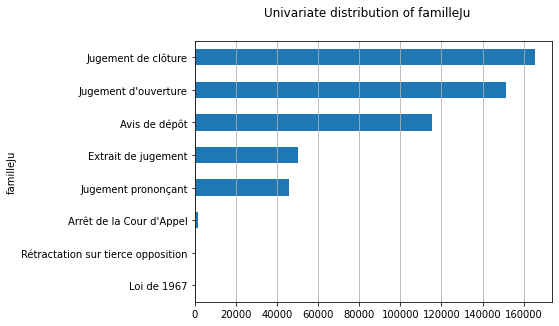

In [44]:
# Define the plot function that we will reuse
def plot_uni_distrib(df, variable, max_cat, figsize, titlesize=12, yticksize=None):
    """
    Plot univariate distribution of variable. Number of categories should be limited to max_cat.
    """
    fig, ax = plt.subplots()
    fig.suptitle(f"Univariate distribution of {variable}", fontsize=titlesize)
    if yticksize:
        ax.tick_params(axis='y', which='major', labelsize=yticksize)
    
    df[variable].reset_index().groupby(variable).count()\
    .sort_values(by="index", ascending=True).iloc[-max_cat:]\
    .plot(kind="barh", legend=False, ax=ax, figsize=figsize).grid(axis='x')
    
    plt.show()
    return None

# Plot familleJu distribution
plot_uni_distrib(df, "familleJu", max_cat=10, figsize=(6.4,4.8), titlesize=12)

In this dataset, we only have 8 judgments'families. Among them, three families are really underrepresented. We have therefore an umbalanced dataset. Now, let's have a look at judgments'nature. 

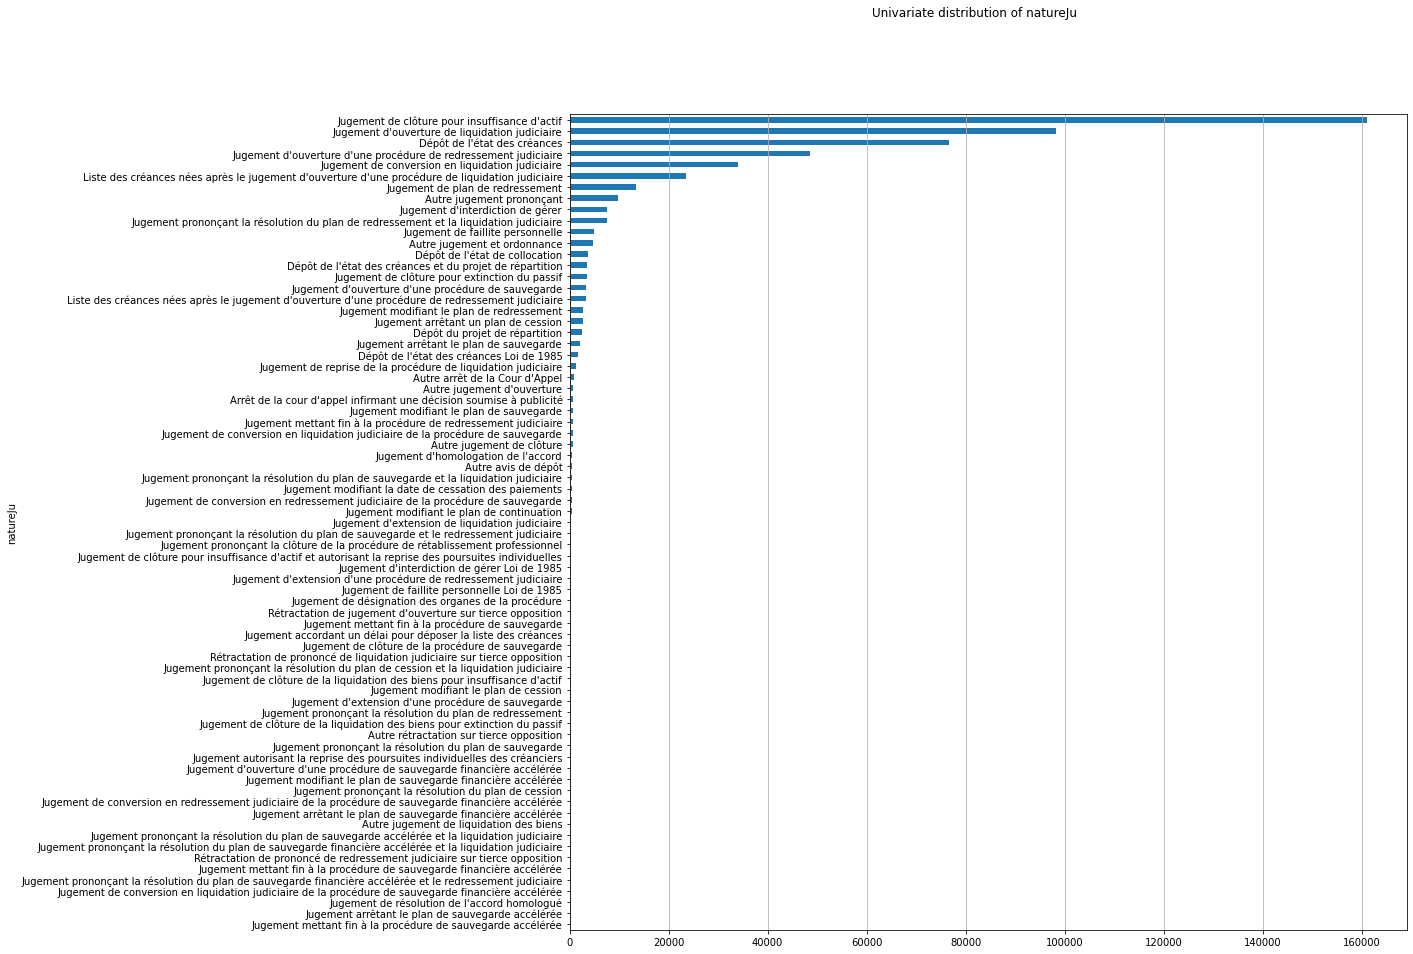

In [45]:
# Plot familleJu distribution
plot_uni_distrib(df, variable="natureJu", max_cat=100, figsize=(15,15), titlesize=12, yticksize=None)

We have more than 73 different judgments'natures. However, a lot of them are under-represented. 27 judgments'natures contains less than 100 PCLAs. 

Then, we can observe the complement of judgment and notice that there are not unique. 

In [51]:
df_compl = df.complementJu.value_counts().to_frame()
print("{} complements of judgment appear more than once in the database".format(df_compl[df_compl.complementJu > 1].shape[0]))
print("They represent {} PCLAs".format(df_compl[df_compl.complementJu > 1].sum().values))
print("Finaly, we only have", len(np.unique(df.complementJu)), "different complements of judgment")
df_compl[df_compl.complementJu > 1].head(8)

23551 complements of judgment appear more than once in the database
They represent [338933] PCLAs
Finaly, we only have 214968 different complements of judgment


complementJu
Jugement prononçant la clôture de la procédure ...        135478
L'état des créances est déposé au greffe où tou...         61806
La liste des créances de l'article L 641-13 du ...         22054
Jugement prononçant la clôture de la procédure ...          3434
L'état des créances complété par le projet de r...          3097
La liste des créances de l'article L 622-17 du ...          3006
Jugement arrêtant le plan de cession.                       2344
Jugement modifiant le plan de redressement.                 2310

Morover, some patterns are very used in the <code>complementJu</code> variable.Indeed : 

In [8]:
#df[df.natureJu=="Jugement de clôture pour insuffisance d'actif"].complementJu.value_counts()
val = df[df.natureJu=="Jugement de clôture pour insuffisance d'actif"].complementJu.value_counts().sum()
print("The pattern 'Jugement de clôture pour insuffisance d'actif' is present in {} PCLAs".format(val))

The pattern 'Jugement de clôture pour insuffisance d'actif' is present in 161001 PCLAs


### &nbsp; &nbsp;  2.3 Text preprocessing <a class="anchor" id="text_prepro"></a>

In [9]:
def utils_preprocess_text(text, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    :requirements : nlp = spacy.load('fr_core_news_md')
    '''
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = text.split("'")
    text = " ".join(text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## Tokenize convert from string to list
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    ## Lemmatize 
    if flg_lemm == True:  
        doc = nlp(" ".join(lst_text))
        lst_text = [word.lemma_ for word in doc]
    
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [10]:
def add_clean_complementJu(df, lst_stopwords):
    '''
    Add a column with clean complementJu (tokenized, lemmatized, stopwords deleted,...)
    :parameter
        :param df: pd.DataFrame that contains a column "complementJu"
        :param lst_stopwords: list - list of stopwords to remove
    :return
        cleaned df
    :requirements : utils_preprocess_text and nlp = spacy.load('fr_core_news_md')
    '''
    df_clean = df.copy()
    #df_clean['complementJu'] = df_clean['complementJu'].astype('string')
    nlp = spacy.load('fr_core_news_md')
    df_clean["complementJu_clean"] = df_clean["complementJu"].apply(lambda x: 
          utils_preprocess_text(x, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
    return df_clean

In [11]:
start = timer()

#df = df.iloc[:10000]
lst_stopwords = nltk.corpus.stopwords.words("french")
df = add_clean_complementJu(df, lst_stopwords)

end = timer()
print("Execution time to preprocess the complement of judgment",timedelta(seconds=end-start))

Execution time to preprocess the complement of judgment 1:10:13.041836


In [12]:
df.to_csv("../data/project_dataset-pcla_2017_to_2019_clean2.csv", sep=";")

## 3 Classification tasks (Supervised and unsupervised) <a class="anchor" id="classif"></a>

In this part we focus our attention on supervised classification. We aim at predicting <code>familleJu</code>  from <code>complementJu_clean</code>. We will try three different approaches : 
- One using Tf-Idf Bag-of-Words
- Word2vec or FastText embeddings 
- BERT 

### &nbsp; &nbsp;  3.1 Problematization <a class="anchor" id="problematization"></a>

Now that we have described and explored data, let's have a look back to the problematic.

Recall that the objective is to group the PCLAs by type in order to know the exact nature of the difficulties faced by the companies.

The families and the natures of PCLA jugements are already grouping PCLAs into categories of 2 different levels of granularity. But are these groups perfectly adapted when it is about to detect the financial difficulties of a company? It is known that these categories are principally designed for an administrative purpose. Therefore, we would like maybe in certain cases to group in the same cluster 2 jugements whith different natures and or to differentiate 2 jugements with the same family. 

Hence, in what follows, we are designing our own clustering using different approaches and comparing the result of each one with the administrative categories.

### &nbsp; &nbsp;  3.2 TF-IDF : a bag of words approach <a class="anchor" id="tf_idf"></a>

### Supervised classification according to <code>familleJu</code> variable 

In [28]:
df = pd.read_csv("../data/project_dataset-pcla_2017_to_2019_clean2.csv", sep =";")

In [29]:
df["familleJu"].value_counts()

Jugement de clôture                   165392
Jugement d'ouverture                  151488
Avis de dépôt                         115605
Extrait de jugement                    50199
Jugement prononçant                    45832
Arrêt de la Cour d'Appel                1603
Rétractation sur tierce opposition       179
Loi de 1967                               52
Name: familleJu, dtype: int64

In [12]:
#df = df[~df["familleJu"].isin(['Rétractation sur tierce opposition', 'Loi de 1967']) ]
#df = df.iloc[:10000]

In [30]:
X = df
y = df["familleJu"].values
df_train, df_test, y_train, y_test = train_test_split(df,y, test_size=0.3, stratify = y)

In [33]:
## Count (classic BoW)
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1,4))
## Tf-Idf (advanced variant of BoW)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,4))

In [34]:
corpus = df_train["complementJu_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
print(X_train.shape)
dic_vocabulary = vectorizer.vocabulary_

(371245, 10000)


Text(0.5, 1.0, 'Sparse Matrix Sample')

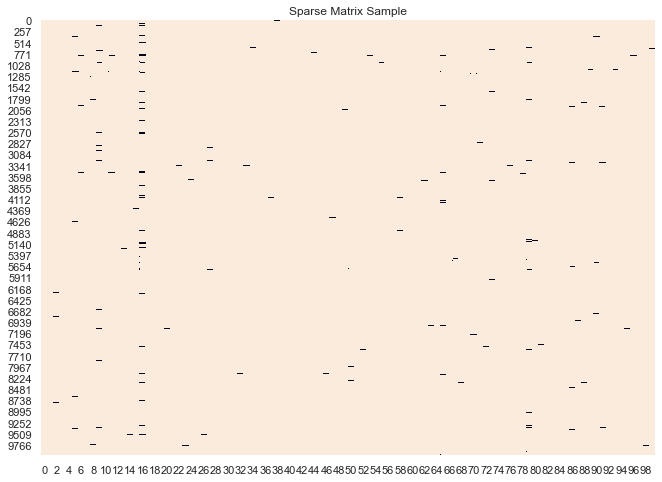

In [35]:
X_train_subset = X_train[:10000]
sns.heatmap(X_train_subset.todense()
            [:,np.random.randint(0,X_train_subset.shape[1],100)]==0, vmin=0, vmax=1, 
            cbar=False).set_title('Sparse Matrix Sample')

In [36]:
word = "jugement"
dic_vocabulary[word]

5378

In [298]:
# from sklearn import feature_selection
# y = df_train["familleJu"]
# X_names = vectorizer.get_feature_names()
# p_value_limit = 0.95
# dtf_features = pd.DataFrame()
# for cat in np.unique(y):
#     chi2, p = feature_selection.chi2(X_train, y == cat)
#     dtf_features = dtf_features.append(pd.DataFrame(
#                        {"feature":X_names, "score":1-p, "y":cat}))
#     dtf_features = dtf_features.sort_values(["y","score"], 
#                         ascending=[True,False])
#     dtf_features = dtf_features[dtf_features["score"]>p_value_limit]

# X_names = dtf_features["feature"].unique().tolist()

In [299]:
# for cat in np.unique(y):
#     print("# {}:".format(cat))
#     print("  . selected features:",
#          len(dtf_features[dtf_features["y"]==cat]))
#     print("  . top features:", ",".join(
# dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
#     print(" ")

In [300]:
# vectorizer = TfidfVectorizer(vocabulary=X_names)
# vectorizer.fit(corpus)
# X_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [37]:

classifier = MultinomialNB()

## pipeline
model = Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["complementJu_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.98
Auc: 0.98
Detail:


C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

          Arrêt de la Cour d'Appel       0.68      0.94      0.79       481
                     Avis de dépôt       1.00      1.00      1.00     34681
               Extrait de jugement       0.97      0.95      0.96     15060
              Jugement d'ouverture       0.98      0.98      0.98     45446
               Jugement de clôture       0.99      0.99      0.99     49618
               Jugement prononçant       0.90      0.91      0.91     13749
                       Loi de 1967       0.00      0.00      0.00        16
Rétractation sur tierce opposition       0.00      0.00      0.00        54

                          accuracy                           0.98    159105
                         macro avg       0.69      0.72      0.70    159105
                      weighted avg       0.98      0.98      0.98    159105



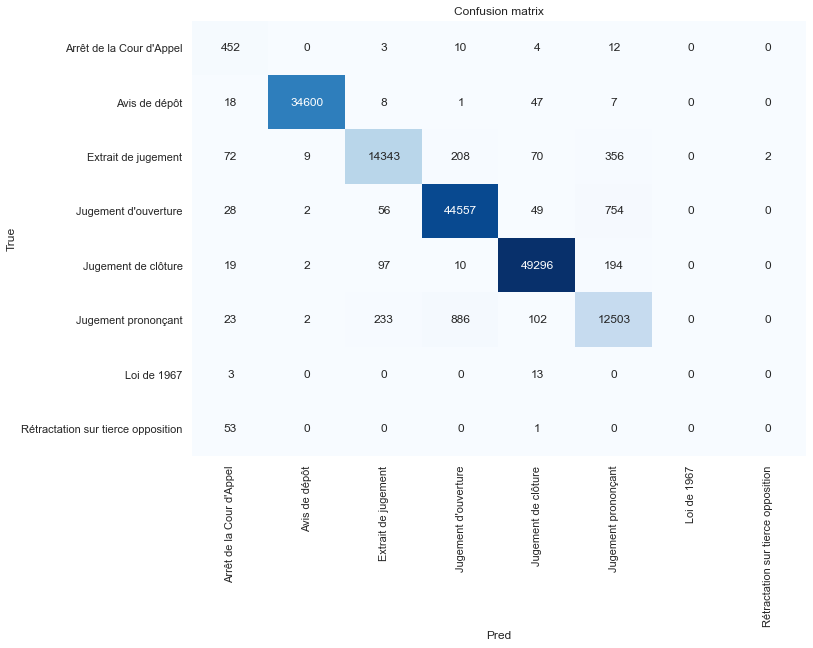

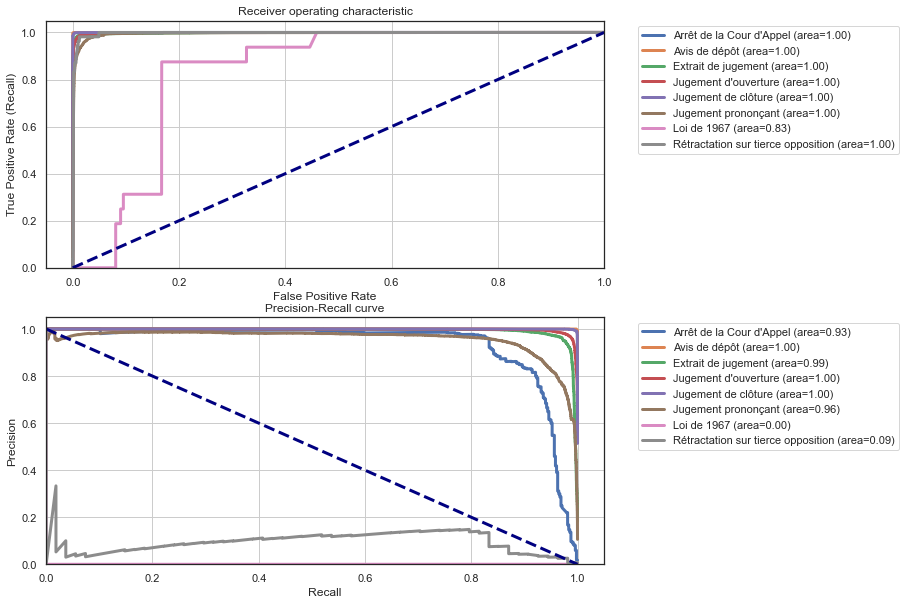

In [38]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy_val = accuracy_score(y_test, predicted)
auc_val = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy_val,2))
print("Auc:", round(auc_val,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision)))
ax[1].plot([0,1], [1,0], color='navy', lw=3, linestyle='--')
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(bbox_to_anchor=(1.05, 1.0))
ax[1].grid(True)
plt.show()

### Unsupervised clustering 

In [43]:
#Define the number of clusters 
nb_classes = len(np.unique(y_train))
#Train Kmeans on the train set 
kmeans = KMeans(n_clusters=nb_classes, random_state=0).fit(X_train)
#Labels of clusters for the train dataset 
kmeans.labels_

array([3, 1, 4, ..., 1, 7, 7])

In [44]:
X_tt = vectorizer.transform(X_test)
labels_tt = kmeans.predict(X_tt)

In [45]:
df_kmeans = pd.DataFrame({'familleJu':df_test.familleJu , 'natureJu': df_test.natureJu, 'cluster' :labels_tt})
df_kmeans

familleJu  \
94961   Jugement d'ouverture   
375517         Avis de dépôt   
68868    Extrait de jugement   
23752    Jugement de clôture   
386254  Jugement d'ouverture   
...                      ...   
137601  Jugement d'ouverture   
392472  Jugement d'ouverture   
141800   Jugement de clôture   
286590  Jugement d'ouverture   
396688   Extrait de jugement   

                                                 natureJu  cluster  
94961      Jugement d'ouverture de liquidation judiciaire        3  
375517  Liste des créances nées après le jugement d'ou...        6  
68868                Jugement arrêtant un plan de cession        5  
23752       Jugement de clôture pour insuffisance d'actif        1  
386254     Jugement d'ouverture de liquidation judiciaire        3  
...                                                   ...      ...  
137601     Jugement d'ouverture de liquidation judiciaire        3  
392472     Jugement d'ouverture de liquidation judiciaire        3  
141800      Jugement de clôture pour insuffisance d'actif        1  
286590  Jugement d'ouverture d'une procédure de redres...        7  
396688                   Jugement d'interdiction de gérer        5  

[159105 rows x 3 columns]

In [47]:
dd = df_kmeans.groupby(["cluster", "familleJu"])['familleJu'].count()
dd = pd.DataFrame(data = dd)
dd = dd.rename(columns = {'familleJu': 'familleJu_count'}, inplace = False) 
dd = dd.reset_index(inplace=False) 
dd['familleJu_percent'] = dd['familleJu_count'] / dd.groupby('cluster')['familleJu_count'].transform('sum') *100

In [48]:
ax = sns.barplot(x="cluster", y ='familleJu_percent', hue="familleJu", data=dd)
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.title('Proportion de chaque famille de jugement dans les clusters')
plt.show()

In [54]:
#Select random indexes in the test set 
indexes = np.random.choice(range(X_tt.shape[0]), 1500 , replace = False)


<1500x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 104217 stored elements in Compressed Sparse Row format>

In [55]:
#Apply TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_tt[indexes,:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.079456
[t-SNE] KL divergence after 300 iterations: 0.974027


In [56]:
#Store informations from TSNE
dfT = pd.DataFrame(tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
dfT['classe'] = y_test[indexes]
dfT

tsne-2d-one  tsne-2d-two                classe
0       -8.748112    -8.874146         Avis de dépôt
1       -2.947963    11.660651   Jugement de clôture
2        7.231167   -11.800049         Avis de dépôt
3       -8.280918    -7.093836         Avis de dépôt
4      -14.467315     0.278329   Jugement de clôture
...           ...          ...                   ...
1495     9.556400     4.152299  Jugement d'ouverture
1496    -1.259376    -4.786963   Extrait de jugement
1497     5.186627     3.370404   Jugement prononçant
1498     6.521537    -3.466116   Extrait de jugement
1499     0.739811    -4.295178   Extrait de jugement

[1500 rows x 3 columns]

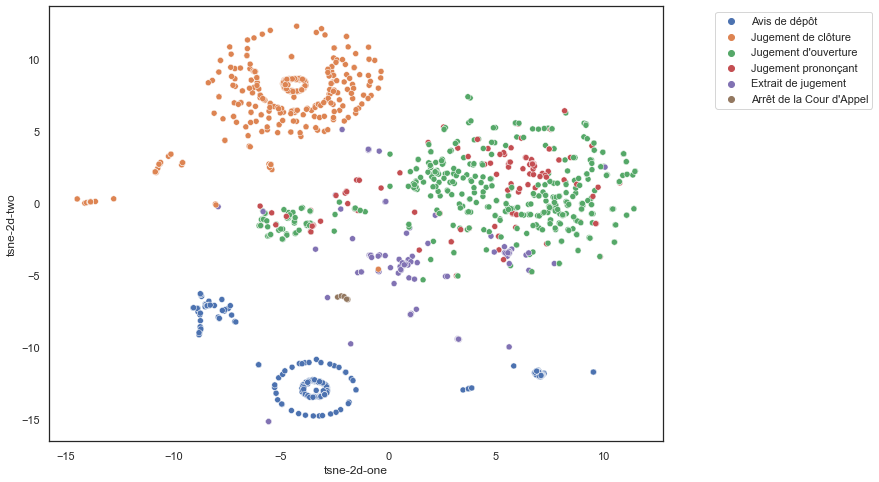

In [57]:
#Plot result from TSNE
ax = sns.scatterplot(data=dfT, x='tsne-2d-one', y='tsne-2d-two', hue="classe")
ax.legend(bbox_to_anchor=(1.35, 1.0))
plt.show()

### &nbsp; &nbsp;  3.3 Word2Vec embeddings <a class="anchor" id="word2vec"></a>

### Supervised classification according to <code>familleJu</code> variable 

In [74]:
df = pd.read_csv("../data/project_dataset-pcla_2017_to_2019_clean2.csv", sep =";")
X = df
y = df["familleJu"].values
df_train, df_test, y_train, y_test = train_test_split(df,y, test_size=0.3, stratify = y)

In [75]:
df_train, df_test, y_train, y_test = train_test_split(df,y, test_size=0.3, stratify = y)
#df_train, df_test, y_train, y_test = train_test_split(df[:10000],y[:10000], test_size=0.3, stratify = y[:10000])

In [76]:

corpus = df_train["complementJu_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [77]:
start = timer()
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)
end = timer()
print(timedelta(seconds=end-start))

0:15:08.086630


<ipython-input-78-7c276b56fa06>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = nlp[tot_words]
C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


['jugement', 'prononcer', 'résolution', 'plan', 'redressement', 'liquidation', 'judiciaire', 'date', 'cessation', 'paiement']


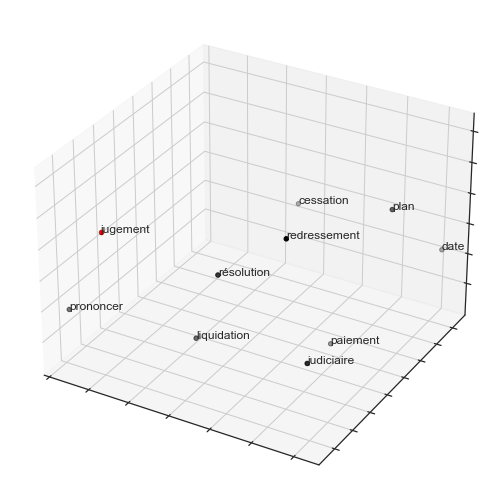

In [78]:
fig = plt.figure(figsize=(9,9))
## word embedding
vocab = nlp.wv.vocab
tot_words = list(vocab)[:10]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3

pca = TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d

ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)
print(tot_words)

In [204]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [205]:
# ## tokenize text
# tokenizer = Tokenizer(lower=True, split=' ', 
#                      oov_token="NaN", 
#                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
# tokenizer.fit_on_texts(lst_corpus)
# dic_vocabulary = tokenizer.word_index
# ## create sequence
# lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
# ## padding sequence
# maxlen = 15
# X_train = pad_sequences(lst_text2seq, 
#                     maxlen=maxlen, padding="post", truncating="post")

In [206]:
# sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
# plt.show()

In [207]:
# i = 0

# ## list of text: ["I like this", ...]
# len_txt = len(df_train["complementJu_clean"].iloc[i].split())
# print("from: ", df_train["complementJu_clean"].iloc[i], "| len:", len_txt)

# ## sequence of token ids: [[1, 2, 3], ...]
# len_tokens = len(X_train[i])
# print("to: ", X_train[i], "| len:", len(X_train[i]))

# ## vocabulary: {"I":1, "like":2, "this":3, ...}
# print("check: ",df_train["complementJu_clean"].iloc[i].split()[0], 
#       " -- idx in vocabulary -->", 
#       dic_vocabulary[df_train["complementJu_clean"].iloc[i].split()[0]])

# print("vocabulary: ", dict(list(dic_vocabulary.items())[0:10]), "... (padding element, 0)")

In [208]:
# corpus = df_test["complementJu_clean"]

# ## create list of n-grams
# lst_corpus = []
# for string in corpus:
#     lst_words = string.split()
#     lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
#                  len(lst_words), 1)]
#     lst_corpus.append(lst_grams)
    
# ## detect common bigrams and trigrams using the fitted detectors
# lst_corpus = list(bigrams_detector[lst_corpus])
# lst_corpus = list(trigrams_detector[lst_corpus])
# ## text to sequence with the fitted tokenizer
# lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# ## padding sequence
# X_test = pad_sequences(lst_text2seq, maxlen=maxlen,
#              padding="post", truncating="post")

In [209]:
# ## start the matrix (length of vocabulary x vector size) with all 0s
# embeddings = np.zeros((len(dic_vocabulary)+1, 300))
# for word,idx in dic_vocabulary.items():
#     ## update the row with vector
#     try:
#         embeddings[idx] =  nlp[word]
#     ## if word not in model then skip and the row stays all 0s
#     except:
#         pass

In [210]:
# word = "jugement"
# print("dic[word]:", dic_vocabulary[word], "|idx")
# print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
#       "|vector")

In [211]:
# from sklearn.naive_bayes import MultinomialNB
# classifier = MultinomialNB()
# from sklearn.pipeline import Pipeline

# ## train classifier
# classifier.fit(X_train, y_train)
# ## test
# predicted = classifier.predict(X_test)
# predicted_prob = classifier.predict_proba(X_test)

In [212]:
# from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve

# classes = np.unique(y_test)
# y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
# ## Accuracy, Precision, Recall
# accuracy = accuracy_score(y_test, predicted)
# auc = roc_auc_score(y_test, predicted_prob, 
#                             multi_class="ovr")
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(classification_report(y_test, predicted))
    
# ## Plot confusion matrix
# cm = confusion_matrix(y_test, predicted)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)
# plt.xticks(rotation=90)

# from sklearn.metrics import auc

# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
# ## Plot roc
# for i in range(len(classes)):
#     fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
#                            predicted_prob[:,i])
#     ax[0].plot(fpr, tpr, lw=3, 
#               label='{0} (area={1:0.2f})'.format(classes[i], 
#                               auc(fpr, tpr)))
# ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
# ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#           xlabel='False Positive Rate', 
#           ylabel="True Positive Rate (Recall)", 
#           title="Receiver operating characteristic")
# ax[0].legend(bbox_to_anchor=(1.05, 1.0))
# ax[0].grid(True)
    
# ## Plot precision-recall curve
# for i in range(len(classes)):
#     precision, recall, thresholds = precision_recall_curve(
#                  y_test_array[:,i], predicted_prob[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   auc(recall, precision)))
# ax[1].plot([0,1], [1,0], color='navy', lw=3, linestyle='--')
# ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#           ylabel="Precision", title="Precision-Recall curve")
# ax[1].legend(bbox_to_anchor=(1.05, 1.0))
# ax[1].grid(True)
# plt.show()

In [79]:
def get_vect(word, model):
    try:
        return nlp.wv[word]
    except KeyError:
        return np.zeros((nlp.vector_size,))

def sum_vectors(phrase, nlp):
    return sum(get_vect(w, nlp) for w in phrase)

def word2vec_features(X, nlp):
    feats = np.vstack([sum_vectors(p, nlp) for p in X])
    return feats

corpus = df_train["complementJu_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
wv_train_feat = word2vec_features(lst_corpus, nlp)
wv_train_feat.shape

(371245, 300)

In [80]:
corpus = df_test["complementJu_clean"]

## create list of n-grams
lst_corpus_test = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)
wv_test_feat = word2vec_features(lst_corpus_test, nlp)
wv_test_feat.shape

(159105, 300)

In [81]:

classifier = LogisticRegression()

## train classifier
classifier.fit(wv_train_feat, y_train)
## test
predicted = classifier.predict(wv_test_feat)
predicted_prob = classifier.predict_proba(wv_test_feat)

C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.99
Auc: 0.99
Detail:


C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

          Arrêt de la Cour d'Appel       0.97      0.93      0.95       481
                     Avis de dépôt       1.00      1.00      1.00     34681
               Extrait de jugement       0.96      0.97      0.96     15060
              Jugement d'ouverture       0.99      0.99      0.99     45446
               Jugement de clôture       1.00      1.00      1.00     49618
               Jugement prononçant       0.94      0.94      0.94     13749
                       Loi de 1967       0.00      0.00      0.00        16
Rétractation sur tierce opposition       1.00      0.85      0.92        54

                          accuracy                           0.99    159105
                         macro avg       0.86      0.83      0.84    159105
                      weighted avg       0.99      0.99      0.99    159105



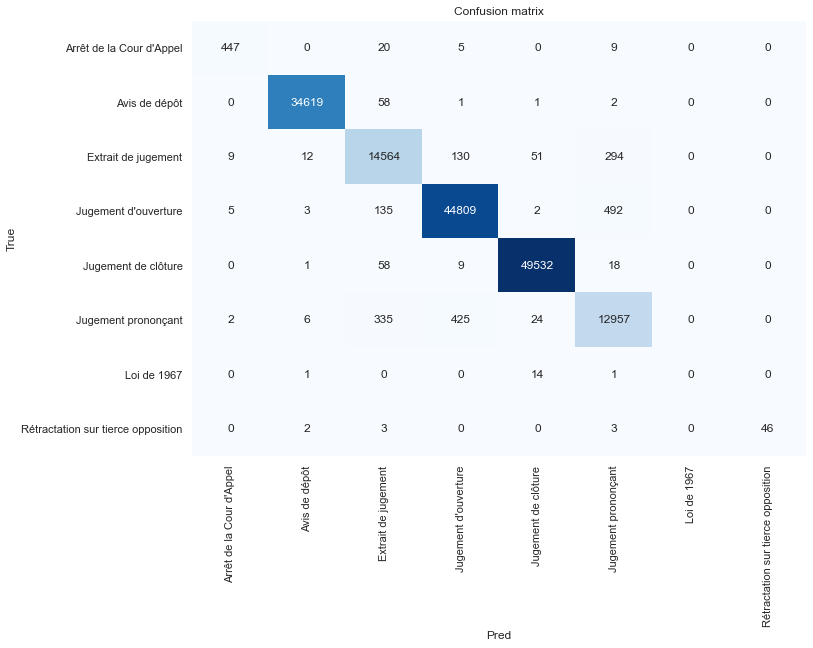

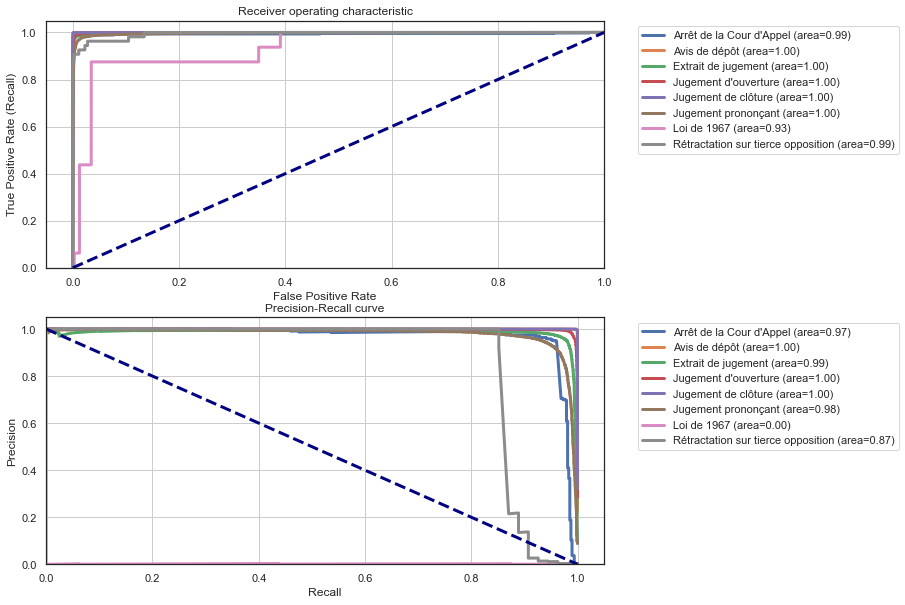

In [82]:

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

from sklearn.metrics import auc

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision)))
ax[1].plot([0,1], [1,0], color='navy', lw=3, linestyle='--')
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(bbox_to_anchor=(1.05, 1.0))
ax[1].grid(True)
plt.show()

### Unsupervised classification

In [83]:
#Convert train/test embeddings to numpy float arrays 
wv_train_feat = wv_train_feat.astype(np.float32)
wv_test_feat = wv_test_feat.astype(np.float32)

In [84]:
#Define the number of clusters 
nb_classes = len(np.unique(y_train))
#Train Kmeans algorithm 
kmeans = KMeans(n_clusters = nb_classes, random_state=0).fit(wv_train_feat)
#Predict cluster for the train set 
labels_tt = kmeans.predict(wv_test_feat)

In [85]:
#Store information from the unsupervised classification 
df_kmeans = pd.DataFrame({'familleJu':df_test.familleJu , 'natureJu': df_test.natureJu, 'cluster' :labels_tt})
df_kmeans

familleJu  \
324745  Jugement d'ouverture   
207844   Jugement de clôture   
314765  Jugement d'ouverture   
307499         Avis de dépôt   
453077   Jugement de clôture   
...                      ...   
329138         Avis de dépôt   
39043          Avis de dépôt   
37043    Jugement de clôture   
44315          Avis de dépôt   
525213   Jugement de clôture   

                                                 natureJu  cluster  
324745  Jugement d'ouverture d'une procédure de redres...        7  
207844      Jugement de clôture pour insuffisance d'actif        3  
314765  Jugement d'ouverture d'une procédure de redres...        7  
307499                       Dépôt de l'état des créances        5  
453077      Jugement de clôture pour insuffisance d'actif        3  
...                                                   ...      ...  
329138                       Dépôt de l'état des créances        2  
39043   Liste des créances nées après le jugement d'ou...        2  
37043       Jugement de clôture pour insuffisance d'actif        3  
44315                        Dépôt de l'état des créances        5  
525213      Jugement de clôture pour insuffisance d'actif        3  

[159105 rows x 3 columns]

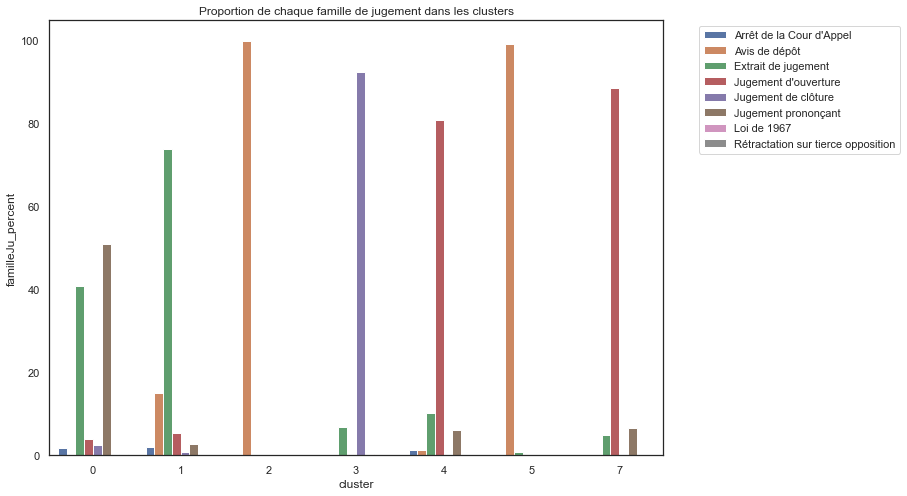

In [86]:
#Transform the dataset 
dd = df_kmeans.groupby(["cluster", "familleJu"])['familleJu'].count()
dd = pd.DataFrame(data = dd)
dd = dd.rename(columns = {'familleJu': 'familleJu_count'}, inplace = False) 
dd = dd.reset_index(inplace=False) 
dd['familleJu_percent'] = dd['familleJu_count'] / dd.groupby('cluster')['familleJu_count'].transform('sum') *100
#Plot results 
ax = sns.barplot(x="cluster", y ='familleJu_percent', hue="familleJu", data=dd)
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.title('Proportion de chaque famille de jugement dans les clusters')
plt.show()

In [87]:
from sklearn.manifold import TSNE
#Select random indexes in the test set 
indexes = np.random.choice(range(len(wv_test_feat)), 1500 , replace = False)
#Apply TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_test_feat[indexes,:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.097s...
[t-SNE] Computed neighbors for 1500 samples in 1.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.224495
[t-SNE] KL divergence after 300 iterations: 0.878096


In [88]:
#Store informations from TSNE
dfT = pd.DataFrame(tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
dfT['classe'] = y_test[indexes]
dfT

tsne-2d-one  tsne-2d-two                classe
0       -4.072314    10.880722   Jugement de clôture
1       -2.590221     9.781280   Jugement de clôture
2        5.151046     0.462586   Jugement prononçant
3      -10.776468     6.949718   Jugement de clôture
4       -7.441231    -8.647479         Avis de dépôt
...           ...          ...                   ...
1495    -6.059917    -9.438800         Avis de dépôt
1496    -3.080951    -1.100041   Extrait de jugement
1497    -2.389026     8.815419   Jugement de clôture
1498     2.137961    -1.147141  Jugement d'ouverture
1499   -11.899512    -0.573915   Extrait de jugement

[1500 rows x 3 columns]

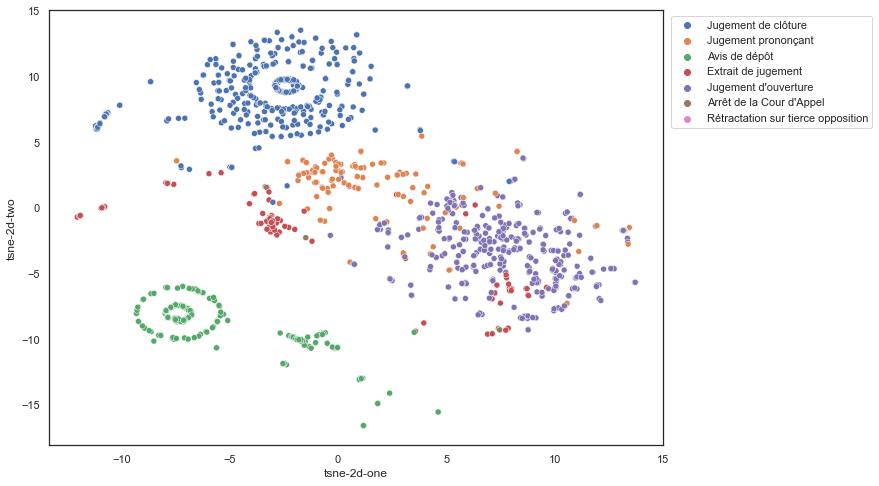

In [89]:
#Plot result from TSNE
ax = sns.scatterplot(data=dfT, x='tsne-2d-one', y='tsne-2d-two', hue="classe")
ax.legend(bbox_to_anchor=(1.35, 1.0))
plt.show()

### &nbsp; &nbsp;  3.4 Word embeddings using a language model :  BERT <a class="anchor" id="bert"></a>

In this part, we will use BERT language model so as to help us building an embedding. 

### Requirements to execute this section

To run this section, you need to run the [general requirements](#general_requirements) and the [specific requirements](#bert_requirements) for this part

### Embedding 

In [6]:
#Define the embedder 
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Unfortunately, we do not have access to GPU. So we should restrict our corpus size. Initially, it was composed of 530350. We have chosen to take into account only 1% of this corpus. In the cell below, you can change the corpus size according to your computing capacity. 

In [8]:
df = pd.read_csv("../data/project_dataset-pcla_2017_to_2019_clean.csv", sep =";")

corpus_len = math.ceil(len(df)*0.01)  
df = df.sample(n=corpus_len, replace = False, random_state = 42)

#Keep judgment families that are represented more than once 
count_ser = df['familleJu'].value_counts()
valid_family = count_ser[count_ser.values >1].index 
df = df[df['familleJu'].isin(valid_family)]

#Define corpus
corpus = df.complementJu.tolist()

In [9]:
#Embedding process 
corpus_embeddings = embedder.encode(corpus, show_progress_bar = True)

### Supervised classification according to <code>familleJu</code> variable

In [10]:
X_train, X_test, y_train, y_test = train_test_split(corpus_embeddings,df['familleJu'], test_size=0.3, stratify = df['familleJu'])

In [11]:
# define classifier
classifier = LogisticRegression()

## train classifier
classifier.fit(X_train, y_train)

## test
predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)

C:\Users\Thomas_JACQUOT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.97
Auc: 1.0
Detail:
                          precision    recall  f1-score   support

Arrêt de la Cour d'Appel       1.00      0.60      0.75         5
           Avis de dépôt       1.00      1.00      1.00       344
     Extrait de jugement       0.97      0.93      0.95       153
    Jugement d'ouverture       0.96      0.98      0.97       466
     Jugement de clôture       1.00      0.99      1.00       479
     Jugement prononçant       0.88      0.90      0.89       144

                accuracy                           0.97      1591
               macro avg       0.97      0.90      0.93      1591
            weighted avg       0.97      0.97      0.97      1591



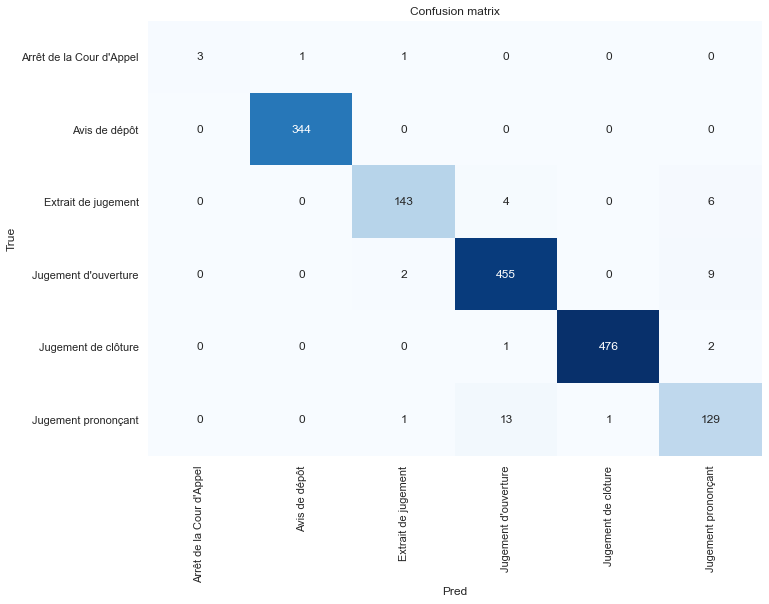

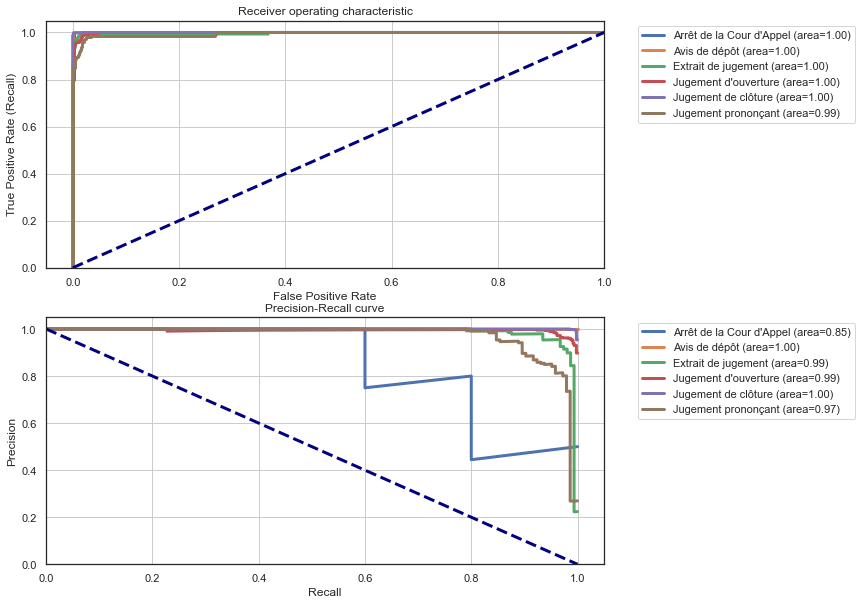

In [12]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy_val = accuracy_score(y_test, predicted)
auc_val = roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy_val,2))
print("Auc:", round(auc_val,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)



fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(1.05, 1.0))
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision)))
ax[1].plot([0,1], [1,0], color='navy', lw=3, linestyle='--')
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(bbox_to_anchor=(1.05, 1.0))
ax[1].grid(True)
plt.show()

### Unsupervised classification

In [19]:
# train k-means
nb_cluster = len(classes)
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(X_train)

#Labels of clusters for the train dataset 
kmeans.labels_

array([3, 2, 1, ..., 5, 4, 0])

In [20]:
labels_tt = kmeans.predict(X_test)

In [21]:
df_test = df.loc[y_test.index]
df_train = df.loc[y_train.index]

In [22]:
df_kmeans = pd.DataFrame({'familleJu':df_test.familleJu , 'natureJu': df_test.natureJu, 'cluster' :labels_tt})
df_kmeans

familleJu  \
290792             Avis de dépôt   
255399  Arrêt de la Cour d'Appel   
449200       Jugement de clôture   
467574             Avis de dépôt   
9283         Jugement prononçant   
...                          ...   
362384             Avis de dépôt   
126213       Jugement prononçant   
495594       Jugement de clôture   
289471      Jugement d'ouverture   
208227      Jugement d'ouverture   

                                                natureJu  cluster  
290792                      Dépôt de l'état des créances        2  
255399                    Autre arrêt de la Cour d'Appel        2  
449200     Jugement de clôture pour extinction du passif        1  
467574                      Dépôt de l'état des créances        2  
9283    Jugement de conversion en liquidation judiciaire        4  
...                                                  ...      ...  
362384                      Dépôt de l'état des créances        3  
126213                         Autre jugement prononçant        4  
495594     Jugement de clôture pour insuffisance d'actif        1  
289471    Jugement d'ouverture de liquidation judiciaire        4  
208227    Jugement d'ouverture de liquidation judiciaire        4  

[1591 rows x 3 columns]

In [23]:
dd = df_kmeans.groupby(["cluster", "familleJu"])['familleJu'].count()
dd = pd.DataFrame(data = dd)
dd = dd.rename(columns = {'familleJu': 'familleJu_count'}, inplace = False) 
dd = dd.reset_index(inplace=False) 
dd['familleJu_percent'] = dd['familleJu_count'] / dd.groupby('cluster')['familleJu_count'].transform('sum') *100

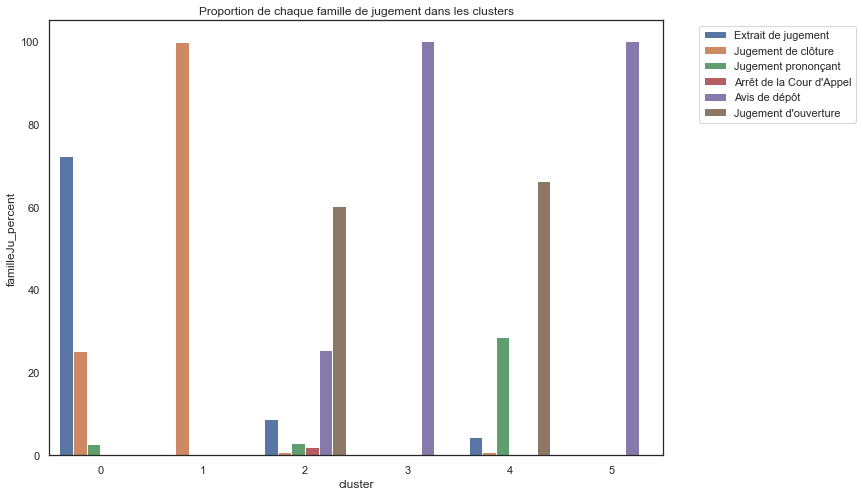

In [24]:
ax = sns.barplot(x="cluster", y ='familleJu_percent', hue="familleJu", data=dd)
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.title('Proportion de chaque famille de jugement dans les clusters')
plt.show()

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1591 samples in 0.259s...
[t-SNE] Computed neighbors for 1591 samples in 3.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1591
[t-SNE] Computed conditional probabilities for sample 1591 / 1591
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.575485
[t-SNE] KL divergence after 300 iterations: 0.855278


In [26]:
dfT = pd.DataFrame(tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
dfT['classe'] = y_test.values 
dfT

tsne-2d-one  tsne-2d-two                    classe
0       -0.068464   -11.428981             Avis de dépôt
1        1.688409    -8.207191  Arrêt de la Cour d'Appel
2       -0.979044     3.860269       Jugement de clôture
3        0.233430   -11.694714             Avis de dépôt
4        3.252245     7.792324       Jugement prononçant
...           ...          ...                       ...
1586    -7.333510   -13.554132             Avis de dépôt
1587     3.018095     6.321812       Jugement prononçant
1588    -7.191592     6.235730       Jugement de clôture
1589     5.326141     2.236554      Jugement d'ouverture
1590     8.500419     2.861202      Jugement d'ouverture

[1591 rows x 3 columns]

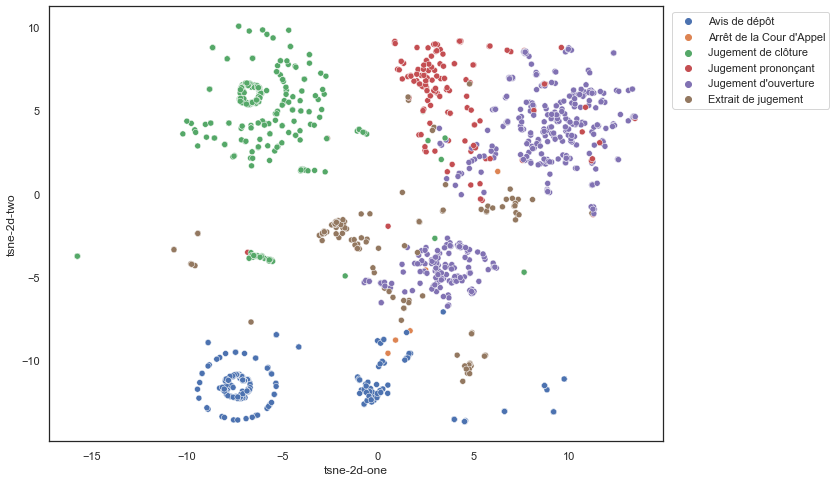

In [27]:
ax = sns.scatterplot(data=dfT, x='tsne-2d-one', y='tsne-2d-two', hue="classe")
ax.legend(bbox_to_anchor=(1.28, 1.0))
plt.show()

In [ ]:
T +

# Brouillon 

- Objectif : construire un modèle génératif qui permet d'associer un PCLA donné à un groupe de PCLA de même sens
- Intérêt : 
    - regrouper sous la même catégorie des familles ou natures de jugement ayant des dénominations différentes mais portant globalement le même sens : (1) ce cas peut arriver lorsque nous travaillons avec des Bodacc publiés sur un intervalle de temps étendu car les dénominations administratives évoluent au fur et à mesure du temps, (2) des catégories peuvent être séparées pour des raisons administratives alors que le contenu des Bodacc de ces catégories est en réalité comparable
    - être en mesure d'associer, lors de l'inférence, la catégorie la plus adaptée parmi celles définies, et ce même si la nature ou la famille du jugement ne faisait pas partie du dataset d'entrainement
- Evaluation quali : 
    - PCA + graphe 2D avec pour label les familles de jugement
    - PCA + graphe 2D avec pour label les natures de jugement
    - PCA + graphe 2D avec pour label les clusters identifiés
- Evaluation quanti : 
    - Proportion des familles de jugement par cluster (ex pour cluster 1 : calculer, pour chacune des 8 familles de jugement, la proportion de documents du cluster 1 appartenant à cette famille de jugement) --> Si clustering correct alors on s'attend à voir apparaître une famille de jugement particulièrement représentée pour chaque famille
    - Proportion des natures de jugement par cluster (idem que pour les familles mais avec 73 natures au lieu de 8 familles)
    - Proportions normalisées : diviser chaque proportion calculée par la proportion de la famille ou de la nature de jugement à l'intérieur du corpus --> Une proportion normalisée supérieure à 1 signifie que la famille ou la nature de jugement à l'étude est plus représentée dans le cluster que dans le corpus

In [ ]:
def unsupervised_result(df, X_train, X_test, y_train, random_state = 0 ):
    """
        df : initial dataframe from which X_train, X_test, y_train are extracted 
        X_train : numpy array of size (n_train, .) 
        X_test : numpy array of size (n_test, .)
        y_train : pandas.Series indicating the cluster name of size (length n_train)
        
    """
    nb_cluster = len(np.unique(y_train))
    #Fit Kmeans
    kmeans = KMeans(n_clusters=nb_cluster, random_state=random_state).fit(X_train)
    #Predict 
    labels_test = kmeans.predict(X_test)
    
    #
    df_test = df.loc[y_test.index]
    
    #compute proportions 
    dd = df_kmeans.groupby(["cluster", "familleJu"])['familleJu'].count()
    dd = pd.DataFrame(data = dd)
    dd = dd.rename(columns = {'familleJu': 'familleJu_count'}, inplace = False) 
    dd = dd.reset_index(inplace=False) 
    dd['familleJu_percent'] = dd['familleJu_count'] / dd.groupby('cluster')['familleJu_count'].transform('sum') *100
    
    #plot proportions results 
    sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
    ax = sns.barplot(x="cluster", y ='familleJu_percent', hue="familleJu", data=dd)
    ax.legend(bbox_to_anchor=(1.05, 1.0))
    plt.title('Proportion of each judgment family in the clusters')
    plt.show()
    
    #T-SNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X_train)
    dfT = pd.DataFrame(tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])
    dfT['cluster'] = y_train.values 

    #plot T-SNE results 
    ax = sns.scatterplot(data=dfT, x='tsne-2d-one', y='tsne-2d-two', hue="cluster")
    ax.legend(bbox_to_anchor=(1.20, 1.0))
    plt.show()


In [ ]:
unsupervised_result(df, X_train, X_test, y_train, random_state = 0 )

In [ ]:
! pip install hydra-core

In [ ]:
! pip install omegaconf

In [ ]:
import torch
camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [ ]:
 from pathlib import Path

In [ ]:
DATA_PATH = Path('data/')
LOG_PATH = Path('logs/')
MODEL_PATH = Path('model/')
LABEL_PATH = Path('labels/')

In [ ]:
val_set = df.sample(frac=0.35, replace=False, random_state = 42)
train_set = df.drop(index = val_set.index)
print("Nombre de compléments de jugement dans le val_set", len(val_set))
print("Nombre de compléments de jugement dans le train_set", len(train_set))
val_set.to_csv('data/val_set.csv')
train_set.to_csv('data/train_set.csv')

In [ ]:
labels = list(df.familleJu.unique())
with open('./labels/labels.txt', 'w') as f : 
    for i in labels : 
        f.write(i+"\n")

In [ ]:
all_texts = df.complementJu.tolist()
print('Nombre de compléments de jugement : ', len(all_texts))

In [ ]:
! pip install fast-bert

In [ ]:
from fast_bert.data_cls import BertDataBunch
databunch_lm = BertLMDataBunch.from_raw_corpus(
                    data_dir = DATA_PATH, 
                    text_list = all_texts, 
                    tokenizer = 'camenbert-base', 
                    batch_size_per_gpu = 10000, 
                    max_seq_length = 512, 
                    multi_gpu = True, 
                    model_type = 'camenbert-base', 
                    logger = logger) 

---

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
sentences = ["I ate dinner.", 
       "We had a three-course meal.", 
       "Brad came to dinner with us.",
       "He loves fish tacos.",
       "In the end, we all felt like we ate too much.",
       "We all agreed; it was a magnificent evening."]

In [ ]:
sentence_embeddings = model.encode(sentences)

#print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
#print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

In [ ]:
! pip install transformers

In [ ]:
nlp.most_similar(word, topn=20)

In [ ]:
txt = df['complementJu_clean'][102]
txt = "12 1222 7778 eee2"

In [ ]:
import re
re.sub('[0-9]{6,20}', '', txt)